# Warnings!! This code may be incorrect!!
I couldn't get the **Pure Trend Following System Data** even with a lot of effort.



I tried to implement what was in the book, but there are parts that are different from the data in the book.


If any feedback Plz Github Issue or contact **dudals3844@gmail.com**


**Thanks for [ChatGPT](https://openai.com/blog/chatgpt/) using ask ambiguous function or ambiguous mathematical expression to correct mathematical expression**

# Chapter 5
# Divergence and the Tradability of Trend

## Measuring Market Divergence at the Portfolio Level

To measure the level of divergence for a particular price series, it is necessary to examine the signal to noise ratio. The signal to noise ratio is a ratio between the trend and individual price changes over a specific period. For any specific day, at time (t), the signal to noise ratio SNRt for a particular price series with lookback period (n) can be calculated mathematically using the following formula:


$$ 
SNR_t(n) = \frac{|P_t - P_{t-n}|}{\sum_{k=0}^{n-1}|P_{t-k} - P_{t-k-1}|}   
\\ (t): at \ time
\\ (n): lookback \ window 
\\ (P_t): price \ at \ time
$$




In [1]:
%load_ext lab_black
# if you use jupyter notebook use nb_black
# %load_ext nb_black

In [2]:
import warnings

warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit

In [3]:
# Set max ouput lines
from notebook.services.config import ConfigManager

cm = ConfigManager().update("notebook", {"limit_output": 10})

In [4]:
yf.pdr_override

<function yfinance.pdr_override()>

### Daily Trend Following Return using Managed Futures ETF or INDEX
**Pick managed futures index  [Barclay CTA Index](https://portal.barclayhedge.com/cgi-bin/indices/displayIndices.cgi?indexID=cta) using trend following returns**

In [5]:
# 100 days rolling almost 3 month returns
trend_following_price = pd.read_csv(
    "../data/barclay_cta_index.csv", parse_dates=["date"], index_col="date"
)["Barclay CTA Index"]

In [6]:
trend_following_returns = trend_following_price.pct_change()

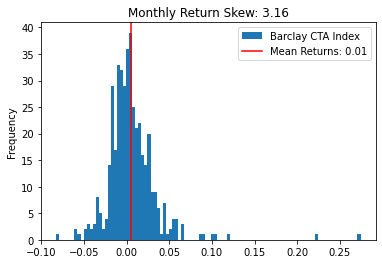

In [7]:
trend_following_returns.plot.hist(bins=100)
mean_returns = trend_following_returns.mean()
plt.axvline(mean_returns, color="r", label=f"Mean Returns: {round(mean_returns, 2)}")
plt.title(f"Monthly Return Skew: {round(trend_following_returns.skew(),2)}")
plt.legend()

### Load Data

In [8]:
end = pd.Timestamp(datetime.now())
start = end - pd.Timedelta(days=365 * 10)

In [9]:
try:
    price = pdr.DataReader("^SPY", data_source="yahoo", start=start, end=end)[
        "Adj Close"
    ]
except:
    price = pd.read_csv(
        "../data/snp_index.csv", parse_dates=["date"], index_col="date"
    )["S&P 500"]

### Calculate SNR

In [10]:
# The book show that lookback window typically chosen at roughly 100 days
lookback_window = 100

In [11]:
x = price.tail(lookback_window)

In [12]:
snr = price.rolling(lookback_window, min_periods=lookback_window).apply(
    lambda x: np.abs(x[-1] - x[0]) / x.diff().abs().sum()
)

<AxesSubplot:xlabel='date'>

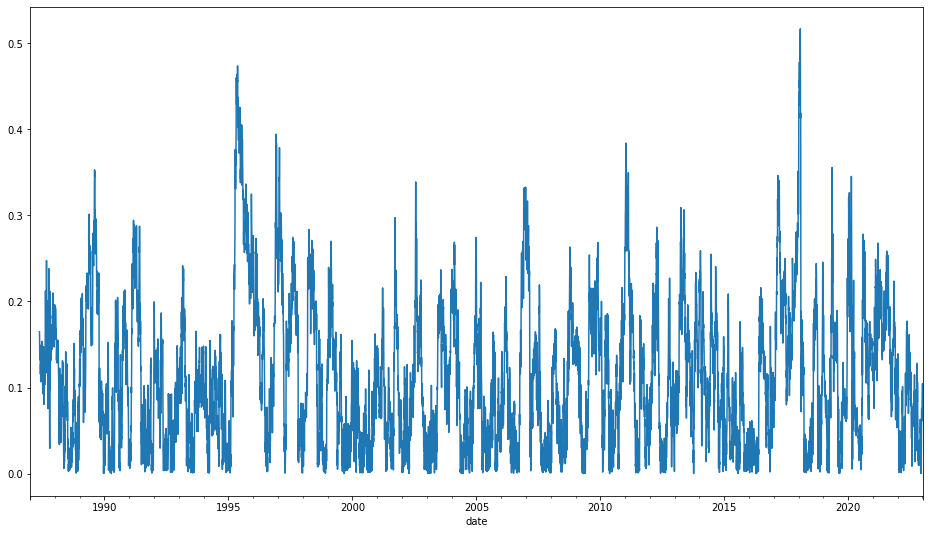

In [13]:
snr.plot(figsize=(16, 9))

The SNR can be calculated for each individual market. The next step is to look at the aggregate level of “trendiness” in markets at the portfolio level. For each individual market (i), for simplicity the total level of market divergence (or “trendiness”) can be calculated as the average signal to noise ratio. This quantity can be defined as the market divergence index (MDI) for a given signal observation period (n)



$$
MDI_t(n) = \frac{1}{M} \sum_{i=1}^{M}SNR_t^i(n)  
\\ M: each \ individual \ market
$$

## Market Divergence and Trend Following Performance
Given that trend following strategies follow trends, the higher the MDI the higher the profitability of a trend following program.

In [14]:
# Load continuous future price

prices = pd.read_csv(
    "../data/futures_continuous_price.csv", parse_dates=["date"], index_col="date"
).dropna()

In [15]:
mdi = (
    prices.rolling(lookback_window, min_periods=lookback_window)
    .apply(lambda x: np.abs(x[-1] - x[0]) / x.diff().abs().sum())
    .mean(axis=1)
    .to_frame("MDI")
)

In [16]:
mdi_monthly = mdi.resample("1M").last().dropna()

In [17]:
# 100 days returns almost 3 month returns
trend_following_returns = trend_following_price.pct_change(3)

In [18]:
mdi_trend_following_returns = mdi.join(trend_following_returns).dropna()

<AxesSubplot:xlabel='date'>

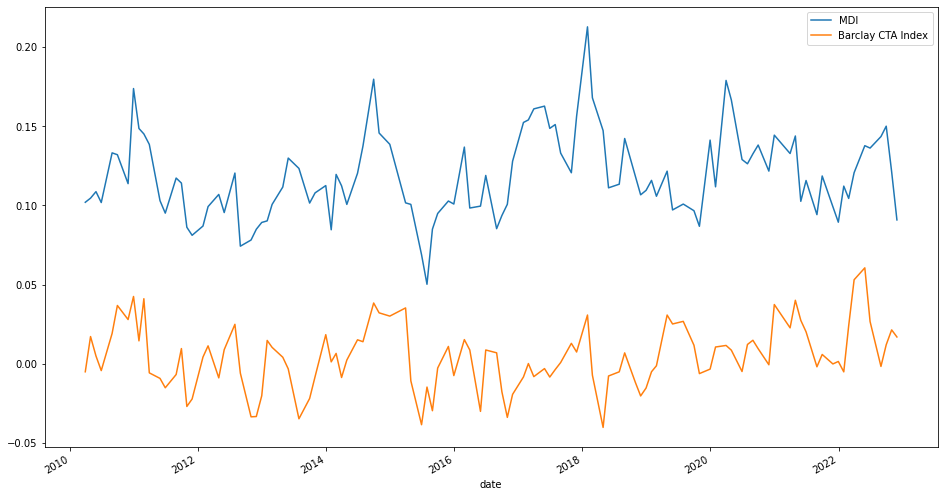

In [19]:
# Figure 5.6
mdi_trend_following_returns.plot(figsize=(16, 9))

<AxesSubplot:>

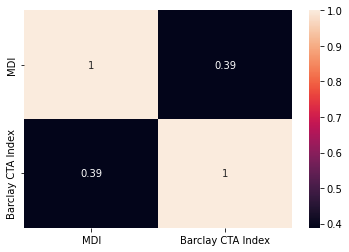

In [20]:
sns.heatmap(mdi_trend_following_returns.corr(), annot=True)

Text(0.5, 0, '100-Day MDI')

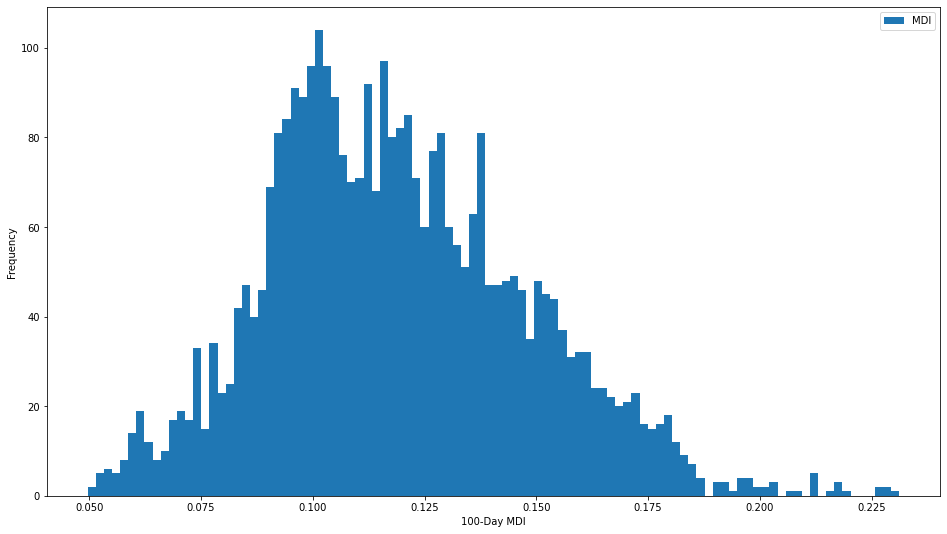

In [21]:
# Figure 5.7
mdi.plot.hist(bins=100, figsize=(16, 9))
plt.xlabel("100-Day MDI")

## Reconnecting to Crisis Alpha and Divergent Risk Taking
it is important to notice that the performance of trend following is linear until market divergence becomes extreme

In [22]:
# 100 days return almost 3 months
trend_following_returns = trend_following_price.pct_change(3)

In [23]:
# If MDI increase returns will be reflect next months
mdi_return = (
    mdi_monthly.shift(1).join(trend_following_returns.to_frame("returns")).dropna()
)

In [24]:
# Filter MDI high value
mdi_return = mdi_return[mdi_return["MDI"] > 0.04]

In [25]:
mdi_return["q"] = pd.qcut(mdi_return["MDI"], q=10, labels=[i for i in range(1, 11)])

In [26]:
mdi_return = mdi_return.groupby("q").mean()

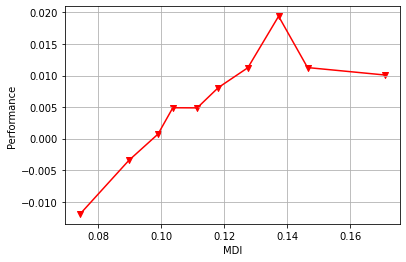

In [27]:
# Figure 5.8
plt.plot(mdi_return["MDI"], mdi_return["returns"], color="r")
plt.scatter(mdi_return["MDI"], mdi_return["returns"], color="r", marker="v")
plt.xlabel("MDI")
plt.grid()
plt.ylabel("Performance")
plt.show()

Remembering that in this example, **the mean value of the MDI(in book) is 0.11**, the conditional performance of trend following portfolios is close to zero for the average MDI value and negative for MDI values below the average MDI value.

In [28]:
mean_mdi = round(mdi["MDI"].mean(), 2)
print(f"When I implemented it myself. Mean MDI: {mean_mdi}")

When I implemented it myself. Mean MDI: 0.12


## The Velocity of the Market Divergence
To examine the speed of the MDI, this section reverts to a classic tool in signal processing, the Fourier transform. A Fourier transform simply transforms a signal from the time domain into the frequency domain


**Fourier transform intergral**
$$
{\displaystyle f(x)=\sum _{n=-\infty }^{\infty }c_{n}\,e^{i2\pi {\tfrac {n}{P}}x}.}
$$

In [29]:
mdi.dropna(inplace=True)

In [30]:
_mdi = mdi.copy()

In [31]:
# Speed is everything~~
@jit
def fourier_transform(x):
    N = len(x)
    X = np.zeros(N, dtype=complex)
    for k in range(N):
        for n in range(N):
            X[k] += x[n] * np.exp(-2j * np.pi * k * n / N)
    return X

In [32]:
%%timeit
fourier_transform([1, 2, 3, 4])

33.5 µs ± 22.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
def power_weighted_average_period(signal):
    fourier = np.fft.fft(signal)

    power = np.abs(fourier) ** 2

    psd = power / len(signal)
    average_period = np.sum(1 / np.arange(1, len(signal) + 1) * psd)
    return average_period, psd

In [34]:
a, b = power_weighted_average_period(_mdi["MDI"])